In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
images = np.load('/content/drive/MyDrive/Data/cats_images.npy') 

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 3072 

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 8, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 6, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   6176        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   73792       batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(latent_dim, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Reshape((32, 32, 3))(x)
x = layers.Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 8, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 6, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary() 

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_4 (Batch (None, 3072)              12288     
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 128)       6272      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      5243

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            reconstruction_loss *= 64 * 64 * 3
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(images, epochs=30, batch_size=128)

Epoch 1/30
124/124 [==============================] - 18s 143ms/step - loss: 466.4457 - reconstruction_loss: 465.9737 - kl_loss: 0.4720
Epoch 2/30
124/124 [==============================] - 18s 144ms/step - loss: 267.2941 - reconstruction_loss: 266.3904 - kl_loss: 0.9036
Epoch 3/30
124/124 [==============================] - 18s 143ms/step - loss: 226.5537 - reconstruction_loss: 225.2469 - kl_loss: 1.3068
Epoch 4/30
124/124 [==============================] - 18s 143ms/step - loss: 205.6609 - reconstruction_loss: 204.2174 - kl_loss: 1.4434
Epoch 5/30
124/124 [==============================] - 18s 143ms/step - loss: 186.6706 - reconstruction_loss: 185.1324 - kl_loss: 1.5382
Epoch 6/30
124/124 [==============================] - 18s 143ms/step - loss: 165.8388 - reconstruction_loss: 164.2979 - kl_loss: 1.5409
Epoch 7/30
124/124 [==============================] - 18s 143ms/step - loss: 156.0187 - reconstruction_loss: 154.4605 - kl_loss: 1.5583
Epoch 8/30
124/124 [============================

In [ ]:
encoder.save('/content/drive/My Drive/Models/cats_enc30.h5')
decoder.save('/content/drive/My Drive/Models/cats_dec30.h5')

In [ ]:
vae.fit(images, epochs=270, batch_size=128)

Epoch 1/270
124/124 [==============================] - 18s 143ms/step - loss: 95.3036 - reconstruction_loss: 93.4337 - kl_loss: 1.8699
Epoch 2/270
124/124 [==============================] - 18s 143ms/step - loss: 86.5154 - reconstruction_loss: 84.6867 - kl_loss: 1.8287
Epoch 3/270
124/124 [==============================] - 18s 143ms/step - loss: 84.4835 - reconstruction_loss: 82.6483 - kl_loss: 1.8353
Epoch 4/270
124/124 [==============================] - 18s 143ms/step - loss: 84.0019 - reconstruction_loss: 82.1642 - kl_loss: 1.8377
Epoch 5/270
124/124 [==============================] - 18s 143ms/step - loss: 83.9060 - reconstruction_loss: 82.0505 - kl_loss: 1.8556
Epoch 6/270
124/124 [==============================] - 18s 143ms/step - loss: 82.7819 - reconstruction_loss: 80.9207 - kl_loss: 1.8612
Epoch 7/270
124/124 [==============================] - 18s 144ms/step - loss: 90.9190 - reconstruction_loss: 89.0190 - kl_loss: 1.9001
Epoch 8/270
124/124 [==============================] - 

In [ ]:
encoder.save('/content/drive/My Drive/Models/cats_enc300.h5')
decoder.save('/content/drive/My Drive/Models/cats_dec300.h5')

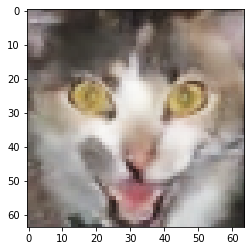

In [ ]:
b = encoder.predict(images[100].reshape(1, 64, 64, 3))
c = decoder.predict(b)
plt.imshow(c.reshape(64, 64, 3))

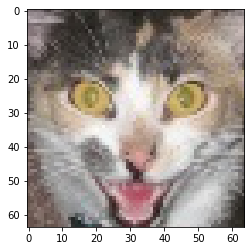

In [ ]:
plt.imshow(images[100])

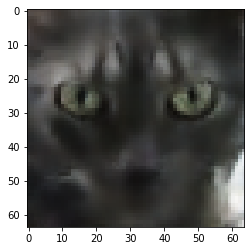

In [ ]:
b = encoder.predict(images[2016].reshape(1, 64, 64, 3))
c = decoder.predict(b)
plt.imshow(c.reshape(64, 64, 3))

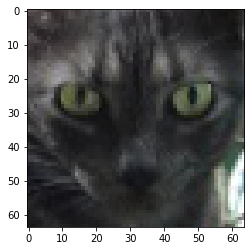

In [ ]:
plt.imshow(images[2016])

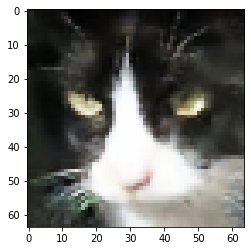

In [ ]:
b = encoder.predict(images[2020].reshape(1, 64, 64, 3))
c = decoder.predict(b)
plt.imshow(c.reshape(64, 64, 3))

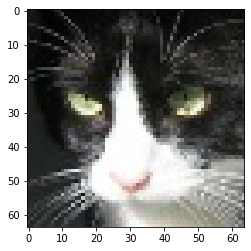

In [ ]:
plt.imshow(images[2020])